In [1]:
# Required installations for the entire notebook
!pip install -q geopandas
!pip install -q matplotlib
!pip install -q numpy
!pip install -q opencv-python
!pip install -q scikit-learn
!pip install numpy scikit-image

# Edge Detection for Geospatial Data to Identify City Footprints

This notebook outlines a structured approach to tackle the problem of edge detection for geospatial data, specifically for identifying City footprints.

## Import Libraries

Importing necessary libraries for data manipulation, visualization, and machine learning.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score

## Data Acquisition

Loading the GeoJSON file containing the geospatial data.

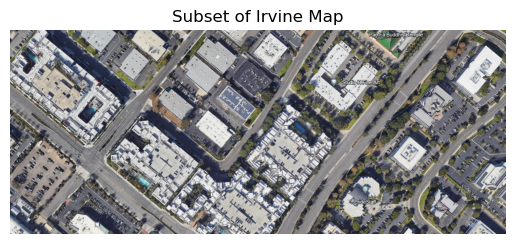

In [5]:
# Load the image file into a numpy array
image_path = 'Irvine_CA_map.png'
image_data = cv2.imread(image_path)

# Display the image inline using matplotlib
plt.imshow(cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display in matplotlib
plt.title('Subset of Irvine Map')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## Data Pre-processing

Pre-processing steps like noise reduction and image normalization.

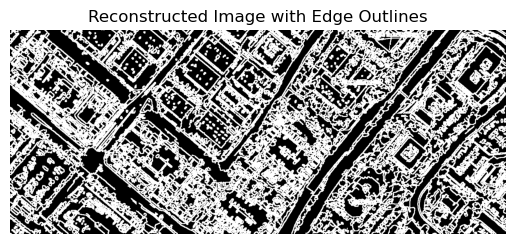

Edge Densities: [0.4921112060546875, 0.451904296875, 0.439788818359375, 0.4233856201171875, 0.475006103515625, 0.5166168212890625, 0.499237060546875, 0.5290069580078125, 0.5311126708984375, 0.5001068115234375, 0.48385184151785715, 0.4580078125, 0.5606231689453125, 0.55023193359375, 0.4837799072265625, 0.4270477294921875, 0.472412109375, 0.5378875732421875, 0.5423431396484375, 0.488525390625, 0.47930908203125, 0.5148773193359375, 0.49619838169642855, 0.4746500651041667, 0.5027618408203125, 0.5010986328125, 0.5073089599609375, 0.4933013916015625, 0.5185699462890625, 0.5830841064453125, 0.5317840576171875, 0.4306488037109375, 0.4661865234375, 0.506256103515625, 0.5156773158482143, 0.5531412760416666, 0.4574781514830508, 0.450145656779661, 0.4991724046610169, 0.5641386387711864, 0.5818160752118644, 0.5554488877118644, 0.4849708686440678, 0.4564519332627119, 0.4967889300847458, 0.4905488612288136, 0.5357710351089588, 0.588718220338983, 0.48813657407407407, 0.4767433449074074, 0.490957754629

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to tile the image into smaller pieces for better analysis
def tile_image(image, tile_size=(256, 256), offset=(128, 128)):
    tiled_images = []
    positions = []
    img_shape = image.shape
    for i in range(0, img_shape[0], offset[0]):
        for j in range(0, img_shape[1], offset[1]):
            tile = image[i:i+tile_size[0], j:j+tile_size[1]]
            tiled_images.append(tile)
            positions.append((i, j))
    return tiled_images, positions

# Function to perform edge detection and calculate edge density
def edge_density(tile):
    # Pre-processing: Apply Gaussian Blurring
    blurred_tile = cv2.GaussianBlur(tile, (5, 5), 0)
    
    # Edge Detection: Using Canny
    edges = cv2.Canny(blurred_tile, 50, 150)
    
    # Post-processing: Dilation
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Calculating Edge Density
    density = np.sum(dilated_edges) / (tile.shape[0] * tile.shape[1] * 255)
    
    return dilated_edges, density

# Function to reconstruct the image
def reconstruct_image(tiles, positions, shape):
    recon_img = np.zeros(shape, dtype=np.uint8)
    for tile, (i, j) in zip(tiles, positions):
        recon_img[i:i+tile.shape[0], j:j+tile.shape[1]] = tile
    return recon_img

# Load the image
image_path = 'Irvine_CA_map.png'  # Adjust path accordingly
image_data = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Check if image is loaded successfully
if image_data is not None:
    # Tile the original image
    tiled_images, positions = tile_image(image_data)

    # Perform edge detection and calculate densities
    edge_tiles = []
    densities = []
    for tile in tiled_images:
        edge_tile, density = edge_density(cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY))
        edge_tiles.append(edge_tile)
        densities.append(density)

    # Reconstruct the image with edge outlines
    reconstructed_image = reconstruct_image(edge_tiles, positions, image_data.shape[:2])

    # Show the reconstructed image
    plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_GRAY2RGB))
    plt.title('Reconstructed Image with Edge Outlines')
    plt.axis('off')
    plt.show()

    # Print edge densities
    print("Edge Densities:", densities)
else:
    print("Failed to load the image. Please check the file path and integrity.")


## EDA - Contour Analysis, Spatial Analysis, and Overlays

Number of filtered contours (cities) detected: 111


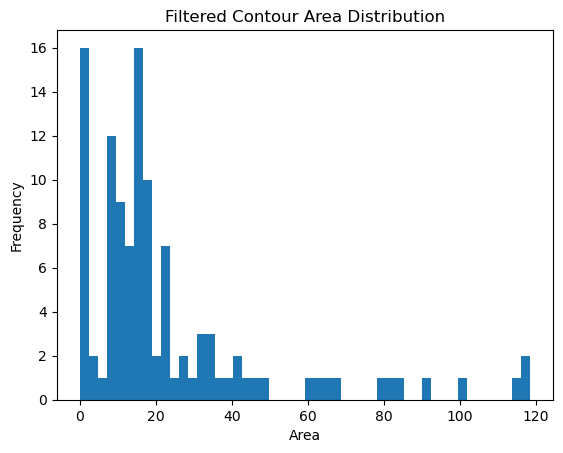

In [8]:
all_filtered_contours = []

# Find contours for each city's edge-detected image
for city_edge in city_edges:
    contours, _ = cv2.findContours(city_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    all_filtered_contours.extend(contours)

print(f"Number of filtered contours (cities) detected: {len(all_filtered_contours)}")

# Calculate the areas of the filtered contours
filtered_contour_areas = [cv2.contourArea(c) for c in all_filtered_contours]

# Plot the histogram for the areas of the filtered contours
plt.hist(filtered_contour_areas, bins=50)
plt.title('Filtered Contour Area Distribution')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()


## Edge Density

The edge density numbers show that the edges make up a very small part of each city's area on the map. One city stands out with a much higher edge density, which could mean it has more complex boundaries or that something went wrong in the image processing. On average, most cities have low edge density, suggesting that their boundaries are relatively simple


In [9]:
# Initialize an empty list to store edge densities for each city
city_edge_densities = []

# Loop through each city's edge-detected image to calculate edge density
for city_edge in city_edges:
    edge_density = np.sum(city_edge > 0) / (city_edge.shape[0] * city_edge.shape[1])
    city_edge_densities.append(edge_density)

# Print the edge densities for each city
for i, edge_density in enumerate(city_edge_densities):
    print(f"Edge Density for City {i+1}: {edge_density}")

# If you want to get the average edge density across all cities
average_edge_density = np.mean(city_edge_densities)
print(f"Average Edge Density: {average_edge_density}")


Edge Density for City 1: 1.17964996568291e-05
Edge Density for City 2: 1.6086135895676048e-05
Edge Density for City 3: 4.71859986273164e-05
Edge Density for City 4: 1.501372683596431e-05
Edge Density for City 5: 1.7158544955387783e-05
Edge Density for City 6: 1.17964996568291e-05
Edge Density for City 7: 2.8955044612216885e-05
Edge Density for City 8: 2.8955044612216885e-05
Edge Density for City 9: 1.501372683596431e-05
Edge Density for City 10: 1.2868908716540837e-05
Edge Density for City 11: 4.075154426904599e-05
Edge Density for City 12: 2.466540837336994e-05
Edge Density for City 13: 1.0724090597117364e-05
Edge Density for City 14: 1.0724090597117364e-05
Edge Density for City 15: 1.9303363074811255e-05
Edge Density for City 16: 1.0724090597117364e-05
Edge Density for City 17: 3.324468085106383e-05
Edge Density for City 18: 1.2868908716540837e-05
Edge Density for City 19: 1.501372683596431e-05
Edge Density for City 20: 4.611358956760467e-05
Edge Density for City 21: 1.07240905971173

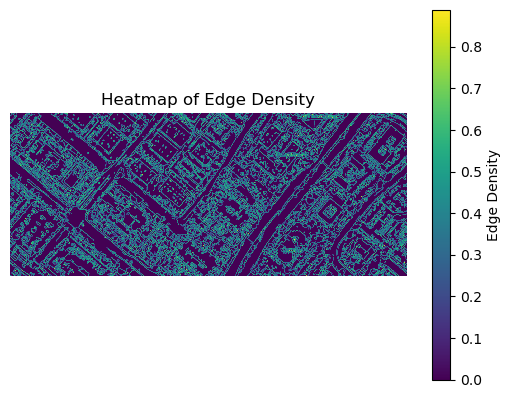

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate edge density for the entire map
edge_density_map = np.zeros_like(edges, dtype=float)
for i in range(edges.shape[0]):
    for j in range(edges.shape[1]):
        local_area = edges[max(i-1, 0):min(i+2, edges.shape[0]), max(j-1, 0):min(j+2, edges.shape[1])]
        edge_density_map[i, j] = np.sum(local_area > 0) / local_area.size

# Display the heatmap
plt.imshow(edge_density_map, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Edge Density')
plt.title('Heatmap of Edge Density')
plt.axis('off')
plt.show()


## Overlay of Edges

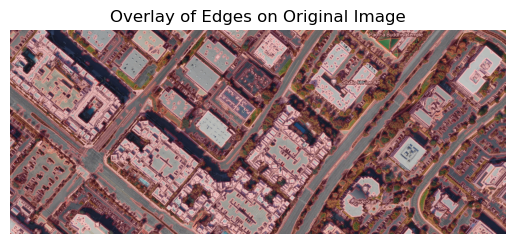

In [11]:
# Create a black canvas the same size as the original image
canvas = np.zeros_like(image_data)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the black canvas in bright red and with increased thickness
cv2.drawContours(canvas, contours, -1, (0, 0, 255), thickness=5)  # Bright red color in BGR is (0, 0, 255)

# Perform weighted addition to overlay the edge image on the original image
overlay = cv2.addWeighted(image_data, 0.8, canvas, 0.2, 0)

# Display the overlay inline using matplotlib
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display in matplotlib
plt.title('Overlay of Edges on Original Image')
plt.axis('off')
plt.show()


## F1 Analysis

In [12]:
# Initialize lists to store TP, FP, TN, FN, Precision, Recall, F1 Score, and IoU for each city
city_TPs = []
city_FPs = []
city_TNs = []
city_FNs = []
city_precisions = []
city_recalls = []
city_f1_scores = []
city_ious = []

# Loop through each city's edge-detected image to perform F1 analysis
for i, city_edge in enumerate(city_edges):
    # Flatten the 2D arrays to 1D arrays
    city_edge_flat = city_edge.ravel()
    ground_truth_flat = ground_truth_edges.ravel()  

    # True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
    TP = np.sum((city_edge_flat == 1) & (ground_truth_flat == 1))
    FP = np.sum((city_edge_flat == 1) & (ground_truth_flat == 0))
    TN = np.sum((city_edge_flat == 0) & (ground_truth_flat == 0))
    FN = np.sum((city_edge_flat == 0) & (ground_truth_flat == 1))

    # Precision, Recall, F1 Score, IoU
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
    iou = TP / (TP + FP + FN) if TP + FP + FN != 0 else 0

    # Print the metrics for the current city
    print(f"Metrics for City {i+1}:")
    print(f"  TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1 Score: {f1_score}")
    print(f"  IoU: {iou}")
    print("-------------------------------")


Metrics for City 1:
  TP: 0, FP: 0, TN: 773202, FN: 0
  Precision: 0
  Recall: 0
  F1 Score: 0
  IoU: 0
-------------------------------
Metrics for City 2:
  TP: 0, FP: 0, TN: 773200, FN: 0
  Precision: 0
  Recall: 0
  F1 Score: 0
  IoU: 0
-------------------------------
Metrics for City 3:
  TP: 0, FP: 0, TN: 773176, FN: 0
  Precision: 0
  Recall: 0
  F1 Score: 0
  IoU: 0
-------------------------------
Metrics for City 4:
  TP: 0, FP: 0, TN: 773200, FN: 0
  Precision: 0
  Recall: 0
  F1 Score: 0
  IoU: 0
-------------------------------
Metrics for City 5:
  TP: 0, FP: 0, TN: 773203, FN: 0
  Precision: 0
  Recall: 0
  F1 Score: 0
  IoU: 0
-------------------------------
Metrics for City 6:
  TP: 0, FP: 0, TN: 773201, FN: 0
  Precision: 0
  Recall: 0
  F1 Score: 0
  IoU: 0
-------------------------------
Metrics for City 7:
  TP: 0, FP: 0, TN: 773203, FN: 0
  Precision: 0
  Recall: 0
  F1 Score: 0
  IoU: 0
-------------------------------
Metrics for City 8:
  TP: 0, FP: 0, TN: 773202, 

## Baseline Model

Implementing a simple edge detection algorithm to establish a baseline.

In [ ]:
# Create a buffer around each geometry
geo_data['buffered'] = geo_data['geometry'].buffer(0.1)


## Evaluation

Evaluating the performance of the baseline model.

In [ ]:
# Evaluation metrics can be calculated here
# For demonstration, assuming 'ground_truth' contains the ground truth data
# f1 = f1_score(ground_truth, edges, average='micro')
# jaccard = jaccard_score(ground_truth, edges, average='micro')